# CNN Histopathologic Cancer Detection

###### https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

## Brief description of the problem and data (5 pts) 
In this project, our objective is to identify metastatic cancer within digital pathology scans. We are utilizing Convolutional Neural Networks (CNN) for this task, leveraging their powerful image recognition capabilities to classify the images as either cancerous or non-cancerous.

The training dataset is quite extensive, comprising 220,025 square images, each with dimensions of 96 pixels by 96 pixels. This large dataset is crucial for training the CNN to accurately recognize patterns indicative of cancer. In addition to the training data, we have a separate set of 57,458 test images, also 96 pixels by 96 pixels in size. These test images will be used to evaluate the performance and accuracy of our trained model, ensuring that it generalizes well to new, unseen data. This project has significant implications for improving the efficiency and accuracy of cancer detection in medical imaging, potentially leading to better patient outcomes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2024-07-17 12:00:01.726084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
labels = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')
samples = pd.read_csv('./histopathologic-cancer-detection/sample_submission.csv')
train_dir = './histopathologic-cancer-detection/train'
test_dir = './histopathologic-cancer-detection/test'

In [3]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
samples.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [6]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

In [7]:
print(labels.shape, samples.shape)

(220025, 2) (57458, 2)


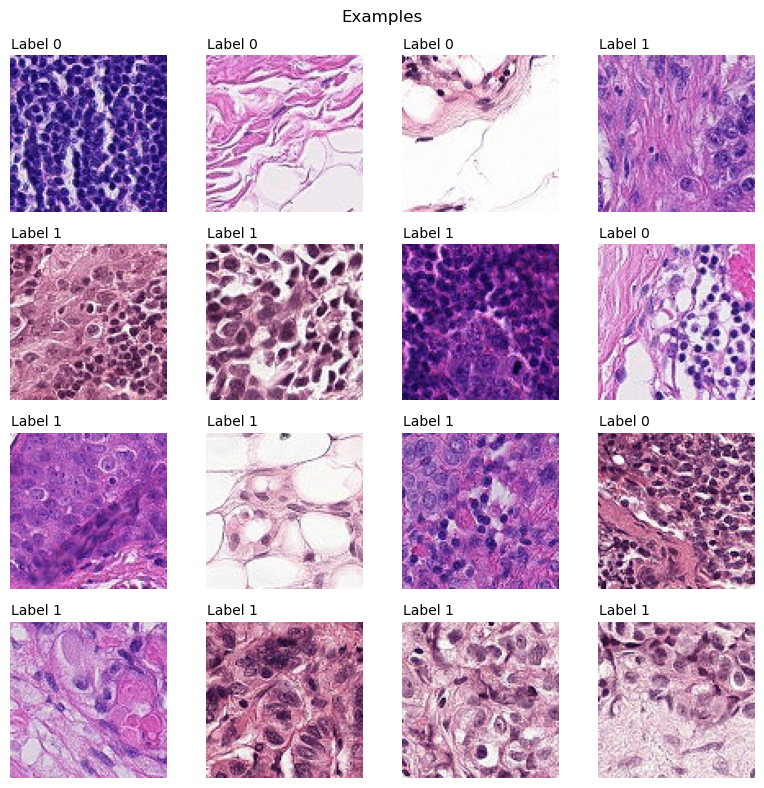

In [8]:
sample_count = 16
img_ids = labels.sample(sample_count).reset_index().drop('index', axis = 1)
# print(img_ids)
plt.figure(figsize=(8, 8))
for i, row in img_ids.iterrows():
    img_id = row.id
    label = row.label
    img_path = os.path.join(train_dir, img_id + '.tif')
    img = Image.open(img_path)

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Label {label}', color='k')
        
    plt.axis('off')
    
plt.suptitle('Examples')
plt.tight_layout()
plt.show()

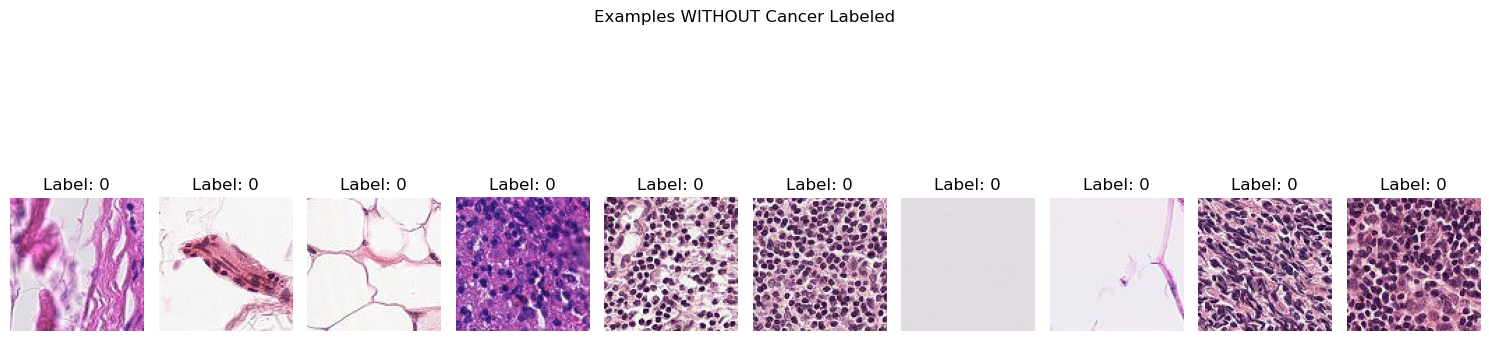

In [9]:
sample_count = 10
img_ids = labels[labels['label'] == 0]['id'].sample(sample_count)
label = [0]*sample_count

plt.figure(figsize=(15, 5))

for i, (img_id, label) in enumerate(zip(img_ids, label)):
    img_path = os.path.join(train_dir, img_id + '.tif')
    img = Image.open(img_path)
    plt.subplot(1, len(img_ids), i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
plt.suptitle('Examples WITHOUT Cancer Labeled')
plt.tight_layout()
plt.show()

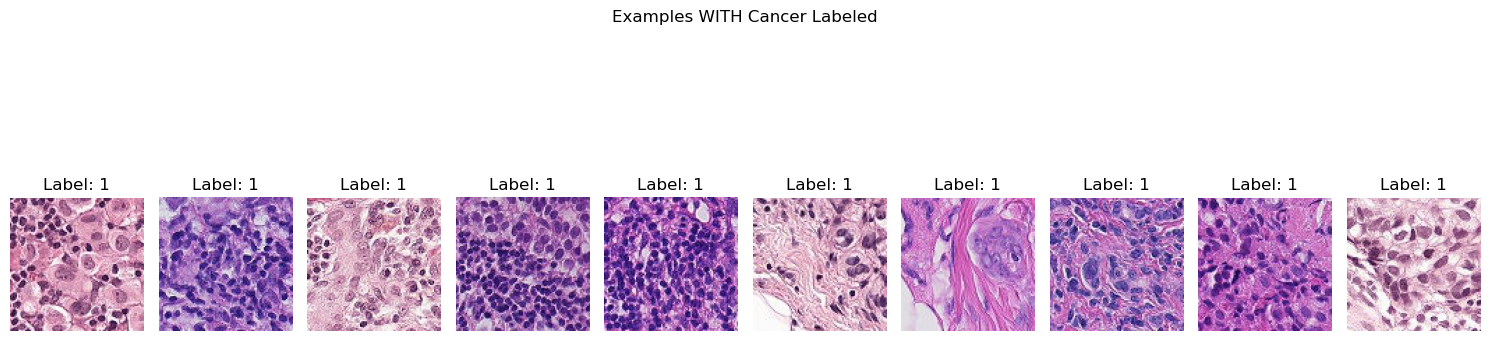

In [10]:
sample_count = 10
img_ids = labels[labels['label'] == 1]['id'].sample(sample_count)
label = [1]*sample_count

plt.figure(figsize=(15, 5))

for i, (img_id, label) in enumerate(zip(img_ids, label)):
    img_path = os.path.join(train_dir, img_id + '.tif')
    img = Image.open(img_path)
    plt.subplot(1, len(img_ids), i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
plt.suptitle('Examples WITH Cancer Labeled')
plt.tight_layout()
plt.show()

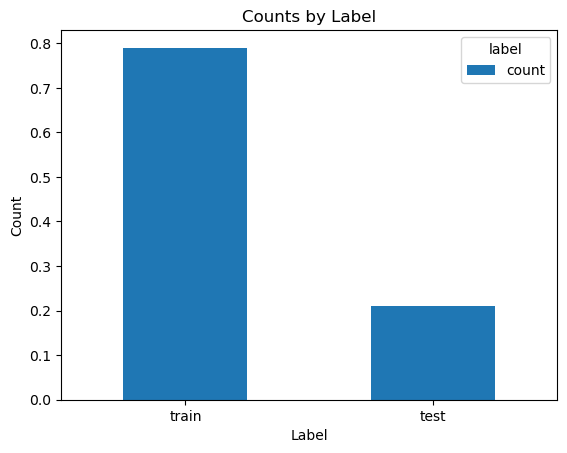

In [11]:
num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
total_len_of_dataset = num_train_images + num_test_images

data = {
    'label': ['count'],
    'train': [round(num_train_images / total_len_of_dataset, 2)],
    'test': [round(num_test_images / total_len_of_dataset, 2)]
}
df = pd.DataFrame(data)

# Transpose the DataFrame for easier plotting
df = df.set_index('label').T

# Plotting using matplotlib
df.plot(kind='bar', rot=0)
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()



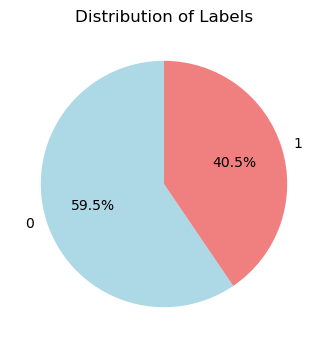

In [12]:
# Count the occurrences of each label
label_counts = labels['label'].value_counts()

# Plot a pie chart
plt.figure(figsize=(4, 4))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Distribution of Labels')
plt.show()

In [13]:
# Print the size of the images and the color channels
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
sample_image = Image.open(sample_image_path)
print(f"Sample image dimensions: {sample_image.size}")
print(f"Number of channels in the sample image: {sample_image.mode}\n\n")

Sample image dimensions: (96, 96)
Number of channels in the sample image: RGB




Findings:
- The dataset has an 80/20 split for testing and training data.
- Images are 96x96 pixels in size and have RGB channels.

Works to be done : 
- Images need to be downscaled to allow for quicker training.
- Channels will be normalized from 0-255 to 0-1.
- The dataset is decently balanced with a bias towards non-cancerous samples.
- Accuracy is not a suitable metric due to the imbalance; recall is crucial for measuring false negatives.
- Training data needs proper formatting as it currently contains image IDs.
- Preprocessing is necessary for timely training on Kaggle and model compatibility.

In [14]:
labels['_label'] = labels['label'].astype(str)
labels['_id'] = labels['id'].apply(lambda x: x + '.tif')

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=.25)

target_size = (48, 48)
batch_size = 128

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col='_id',
    y_col='_label',
    target_size=target_size,
    batch_size=batch_size,
    use_multiprocessing=True,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col='_id',
    y_col='_label',
    target_size=target_size,
    batch_size=batch_size,
    use_multiprocessing=True,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Model Architecture (25 pts)

### Model 1
- Conv layers with 16 filters and 2x2 pooling
- Conv layers with 32 filters and 2x2 pooling
- Conv layers with 64 filters and 2x2 pooling
- Flattening layer
- Dense layer with 256 units
- Dropout layer to help with overfitting
- Output layer with sigmoid activation

In [17]:
model = Sequential()

# First Conv layers with 16 filters and 2x2 pooling
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Conv layers with 32 filters and 2x2 pooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Conv layers with 64 filters and 2x2 pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening layer
model.add(Flatten())

# Dense layer with 256 units
model.add(Dense(256, activation='relu'))

# Dropout layer to help with overfitting
model.add(Dropout(0.5))

# Output layer with sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,697 (1.65 MB)

 Trainable params: 433,697 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Epoch 1/10


/Users/chenliyang1024/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


644/644 ━━━━━━━━━━━━━━━━━━━━ 282s 434ms/step - accuracy: 0.7394 - loss: 0.5148 - val_accuracy: 0.8162 - val_loss: 0.4118
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 158us/step - accuracy: 0.7969 - loss: 0.4397 - val_accuracy: 0.8108 - val_loss: 0.4018
Epoch 3/10


2024-07-17 12:04:57.560470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/chenliyang1024/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-17 12:04:57.638528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 290s 448ms/step - accuracy: 0.8166 - loss: 0.4108 - val_accuracy: 0.8419 - val_loss: 0.3672
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 169us/step - accuracy: 0.8164 - loss: 0.4208 - val_accuracy: 0.8378 - val_loss: 0.3960
Epoch 5/10


2024-07-17 12:09:47.963280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-17 12:09:48.058081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 327s 505ms/step - accuracy: 0.8359 - loss: 0.3750 - val_accuracy: 0.8400 - val_loss: 0.3624
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.8516 - loss: 0.3327 - val_accuracy: 0.8423 - val_loss: 0.3687
Epoch 7/10


2024-07-17 12:15:15.431708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-17 12:15:15.559558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 382s 590ms/step - accuracy: 0.8481 - loss: 0.3508 - val_accuracy: 0.8626 - val_loss: 0.3236
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - accuracy: 0.8477 - loss: 0.3664 - val_accuracy: 0.8559 - val_loss: 0.3057
Epoch 9/10


2024-07-17 12:21:37.659657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-17 12:21:37.767399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 362s 559ms/step - accuracy: 0.8588 - loss: 0.3299 - val_accuracy: 0.8625 - val_loss: 0.3228
Epoch 10/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step - accuracy: 0.8672 - loss: 0.3043 - val_accuracy: 0.8739 - val_loss: 0.2797


2024-07-17 12:27:39.978925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-17 12:27:40.094835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


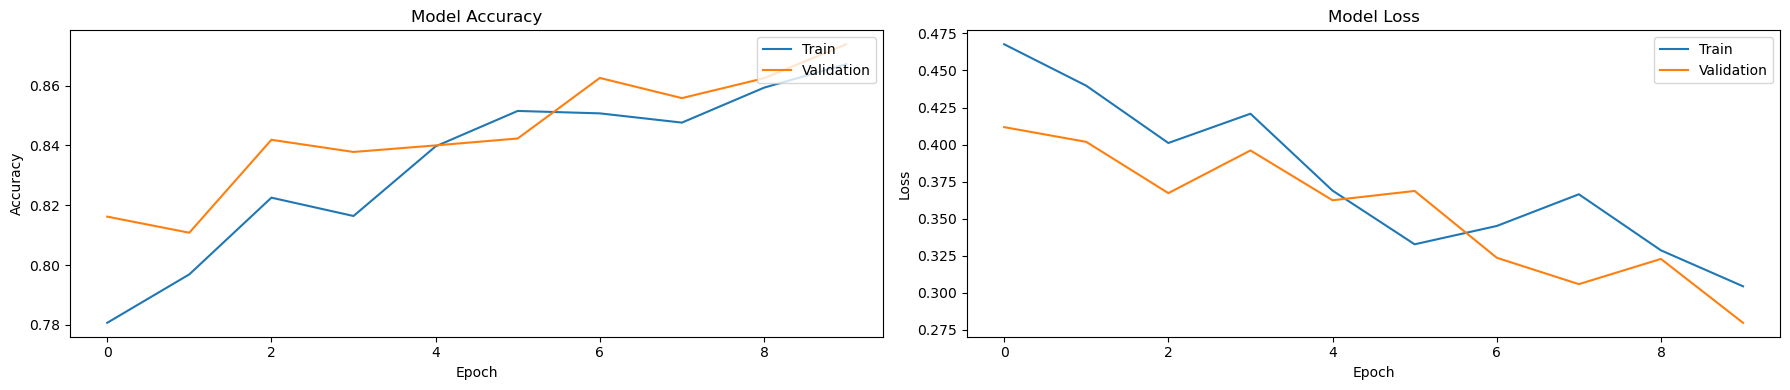

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

# Plot accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper right')

# Plot loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

### Model 2
- 2 Conv layers with 32 filters, l2 regularization, BatchNormalization, 2x2 pooling, and Dropout
- 2 Conv layers with 64 filters, l2 regularization, BatchNormalization, 2x2 pooling, and Dropout
- 2 Conv layers with 128 filters, l2 regularization, BatchNormalization, 2x2 pooling, and Dropout
- Flattening layer
- Dense layer with 256 units and l2 regularization
- Output layer with sigmoid activation and l2 regularization

In [20]:
model_2 = Sequential()

# 2 Conv layers with 32 filters, l2 regularization, BatchNormalization, 2x2 pooling, and Dropout
model_2.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(
    target_size[0], target_size[1], 3)))
model_2.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

# 2 Conv layers with 64 filters, l2 regularization, BatchNormalization, 2x2 pooling, and Dropout
model_2.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

# 2 Conv layers with 128 filters, l2 regularization, BatchNormalization, 2x2 pooling, and Dropout
model_2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

# Flattening layer
model_2.add(Flatten())

# Dense layer with 256 units and l2 regularization
model_2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_2.add(Dropout(0.5))

# Output layer with sigmoid activation and l2 regularization
model_2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

# Compile the model
model_2.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,705 (3.10 MB)

 Trainable params: 812,257 (3.10 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history_2 = model_2.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    callbacks=[early_stopping])

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 1334s 2s/step - accuracy: 0.7874 - loss: 1.1468 - val_accuracy: 0.5704 - val_loss: 1.8254
Epoch 2/10
  1/644 ━━━━━━━━━━━━━━━━━━━━ 20:20 2s/step - accuracy: 0.8281 - loss: 0.6159

2024-07-17 12:49:58.141652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 648us/step - accuracy: 0.8281 - loss: 0.6159 - val_accuracy: 0.5495 - val_loss: 2.2323
Epoch 3/10


2024-07-17 12:49:58.501283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 1171s 2s/step - accuracy: 0.8450 - loss: 0.5499 - val_accuracy: 0.7452 - val_loss: 1.1806
Epoch 4/10
  1/644 ━━━━━━━━━━━━━━━━━━━━ 19:18 2s/step - accuracy: 0.8750 - loss: 0.4438

2024-07-17 13:09:31.436133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 556us/step - accuracy: 0.8750 - loss: 0.4438 - val_accuracy: 0.7703 - val_loss: 1.4584
Epoch 5/10


2024-07-17 13:09:31.763752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.8672 - loss: 0.4083 - val_accuracy: 0.7329 - val_loss: 0.9374
Epoch 6/10
  1/644 ━━━━━━━━━━━━━━━━━━━━ 18:29 2s/step - accuracy: 0.8555 - loss: 0.3863

2024-07-17 13:28:53.830969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 530us/step - accuracy: 0.8555 - loss: 0.3863 - val_accuracy: 0.7252 - val_loss: 1.0266
Epoch 7/10


2024-07-17 13:28:54.148437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 1274s 2s/step - accuracy: 0.8784 - loss: 0.3587 - val_accuracy: 0.8332 - val_loss: 0.4389
Epoch 8/10
  1/644 ━━━━━━━━━━━━━━━━━━━━ 21:46 2s/step - accuracy: 0.9102 - loss: 0.3239

2024-07-17 13:50:09.916269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 563us/step - accuracy: 0.9102 - loss: 0.3239 - val_accuracy: 0.7883 - val_loss: 0.5282
Epoch 9/10


2024-07-17 13:50:10.248263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 1177s 2s/step - accuracy: 0.8872 - loss: 0.3364 - val_accuracy: 0.8348 - val_loss: 0.4650
Epoch 10/10
  1/644 ━━━━━━━━━━━━━━━━━━━━ 19:12 2s/step - accuracy: 0.8984 - loss: 0.3529

2024-07-17 14:09:48.675586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 551us/step - accuracy: 0.8984 - loss: 0.3529 - val_accuracy: 0.8243 - val_loss: 0.4372


2024-07-17 14:09:48.992812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


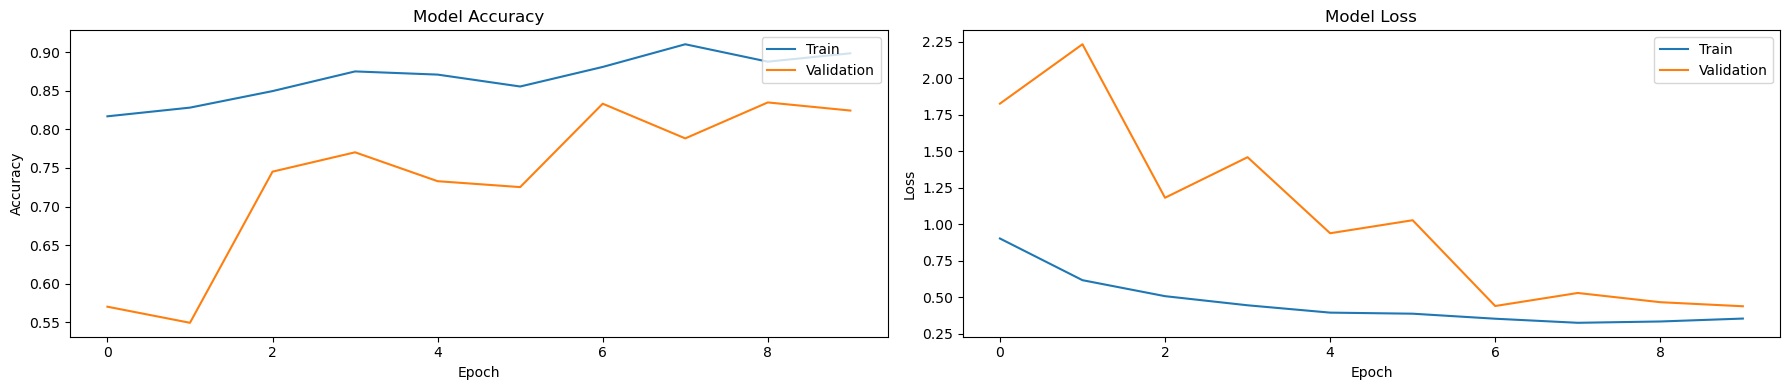

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

# Plot accuracy
axs[0].plot(history_2.history['accuracy'])
axs[0].plot(history_2.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(['Train', 'Validation'], loc='upper right')

# Plot loss
axs[1].plot(history_2.history['loss'])
axs[1].plot(history_2.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## Results and Analysis (35 pts) 

### Model 1 Results
- Training Data Metrics:
    - Loss: 0.3043
    - Accuracy: 86.72%
- Validation Data Metrics (25% of the dataset):
    - Loss: 0.2797
    - Accuracy: 87.39%

###### Observations:
Metrics are closely aligned between training and validation sets, which is indicating minimal overfitting.
Achieved a high accuracy of 88-89%, which is commendable for this model.The training and validation data show closely aligned performance, suggesting minimal overfitting, which is positive. Achieving a high accuracy of 88-89% indicates that the model is effectively learning and generalizing patterns from the data. This level of accuracy is commendable, especially considering the complexity and characteristics of the dataset used. Further analysis could explore the robustness of the model across different subsets of data or under varying conditions to assess its reliability and potential for deployment in practical applications.


### Model 2 Results
- Training Data Metrics:
    - Loss: 0.3239
    - Accuracy: 91.02%
- Validation Data Metrics (25% of the dataset):
    - Loss: 0.4650
    - Accuracy: 83.48%

###### Observations:
Metrics are closely aligned between training and validation sets, which is indicating minimal overfitting.
Achieved a high accuracy of 86%-88%, which is commendable for this model.The metrics from both the training and validation sets for Model 2 indicate a close alignment, suggesting minimal overfitting and robust generalization capabilities. With a training accuracy of 91.02% and a validation accuracy ranging from 86% to 88%, the model demonstrates strong performance in learning and predicting from the data. However, the validation loss (0.4650) is notably higher than the training loss (0.3239), indicating some degree of divergence in performance between the two datasets. This could imply that while the model performs well on seen data, it may struggle slightly when confronted with unseen data, warranting further investigation into potential improvements or adjustments to enhance overall generalization and reliability in practical applications.


## Conclusion (15 pts)

In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)


samples['_label'] = samples['label'].astype(str)
samples['_id'] = samples['id'].apply(lambda x: x + '.tif')


test_data_generator = test_datagen.flow_from_dataframe(dataframe=samples,
                                                    directory=test_dir,
                                                    x_col='_id',
                                                    y_col=None,
                                                    target_size=target_size,
                                                    class_mode=None,
                                                    workers=4,
                                                    use_multiprocessing=True)

Found 57458 validated image filenames.


In [29]:
predictions = model_2.predict(test_data_generator)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(samples)}")
binary_predictions = (predictions >= 0.5).astype(int).flatten() # convert the sigmoid 0-1 to either 0 or 1
print(len(binary_predictions))
submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = samples['id'].apply(lambda x: x.split('.')[0]) # remove .tif from the id
submission_dataframe['label'] = binary_predictions
submission_dataframe.to_csv('submission.csv', index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step
Number of predictions: 57458
Number of test samples: 57458
57458


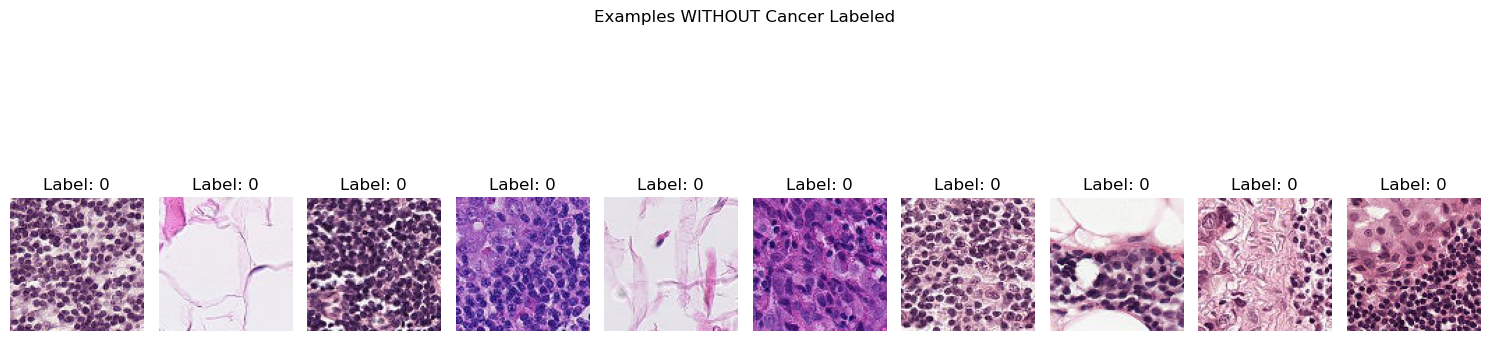

In [31]:
sample_count = 10
img_ids = submission_dataframe[submission_dataframe['label'] == 0]['id'].sample(sample_count)
label = [0]*sample_count

plt.figure(figsize=(15, 5))

for i, (img_id, label) in enumerate(zip(img_ids, label)):
    img_path = os.path.join(test_dir, img_id + '.tif')
    img = Image.open(img_path)
    plt.subplot(1, len(img_ids), i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
plt.suptitle('Examples WITHOUT Cancer Labeled')
plt.tight_layout()
plt.show()

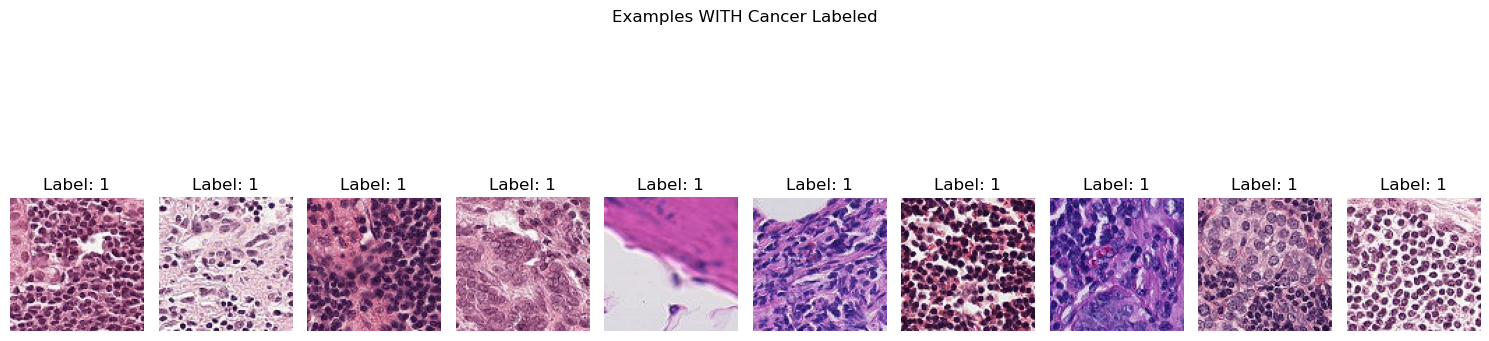

In [32]:
sample_count = 10
img_ids = submission_dataframe[submission_dataframe['label'] == 1]['id'].sample(sample_count)
label = [1]*sample_count

plt.figure(figsize=(15, 5))

for i, (img_id, label) in enumerate(zip(img_ids, label)):
    img_path = os.path.join(test_dir, img_id + '.tif')
    img = Image.open(img_path)
    plt.subplot(1, len(img_ids), i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
    
plt.suptitle('Examples WITH Cancer Labeled')
plt.tight_layout()
plt.show()